# Determines South Facing Vertical Solar for TMY2 & TMY3 AK Sites

In [1]:
# Libraries
from __future__ import division
import json
import os
from matplotlib.pyplot import *
import pandas as pd
import numpy as np
import requests
#import tmy_ids

# Show Plots in the Notebook
%matplotlib inline

# Make Plots larger
rcParams['figure.figsize']= (10, 6)
rcParams['font.size'] = 14

In [2]:
# PVWatts Helper functions.  PVWatts is used to calculate vertical south-facing solar.

def pvw_inputs():
    '''Returns a default set of PVWatts inputs.
    Note that there are other inputs documented here:  http://developer.nrel.gov/docs/solar/pvwatts-v5/
    For example, the 'timeframe' input will allow you to get back hourly results if you want.
    '''
    # substitute your NREL API Key here.  Dustin's key:  4kV70P6KKoeySaf4ZCEmEtQRZt7ngjrPtzo0zUKB 
    # See: http://developer.nrel.gov/docs/api-key/
    p = {'api_key': '4kV70P6KKoeySaf4ZCEmEtQRZt7ngjrPtzo0zUKB'}
    p['system_capacity'] = 1.0
    p['module_type'] = 0
    p['losses'] =  14
    p['array_type'] = 0
    p['azimuth'] =  180.0
    p['tilt'] = 48
    return p

def pvwatts(inputs):
    '''Run PVWatts and return the results as a Python dictionary.
    '''
    res = json.loads(requests.get('http://developer.nrel.gov/api/pvwatts/v5.json', params=inputs).text)
    # separate out just the outputs of the run and return that as the first element of the tuple.
    # The second return item is the full results dictionary which includes the inputs as well.
    return res['outputs'], res


In [3]:
def calc_solar(file_id):
    '''Runs PVWatts for south facing vertical using the climate data in 
    the climate file with id 'file_id'.  Returns key results in a dictionary.
    '''
    inputs = pvw_inputs()
    inputs['file_id'] = file_id
    inputs['tilt'] = 90    # get vertical solar
    outs, all = pvwatts(inputs)
    results = {'latitude': all['station_info']['lat'], 
               'longitude': all['station_info']['lon'],
               'elevation': all['station_info']['elev'],
               'south_vert_solar': round(outs['solrad_annual'], 2)
              }
    return results
    

In [4]:
# Test the function
calc_solar('0-26451')

{'elevation': 35.0,
 'latitude': 61.16666793823242,
 'longitude': -150.01666259765625,
 'south_vert_solar': 2.38}

In [5]:
# If the Pickle file exists, unpickle the DataFrame instead of recreating it to save time.
# (To force a recreate, delete 'solar.pkl')
if os.path.exists('solar.pkl'):
    print 'Unpickling Solar DataFrame'
    df = pd.read_pickle('solar.pkl')

else:
    # Calculate the solar values.
    # Create a list of dictionaries.  Each dictionary contains the solar results for
    # one site and some site info.  This list is used to create a Pandas DataFrame
    # in the next step.
    results = []

    for id, site in tmy_ids.tmy2_ids:
        res = calc_solar('0-%s' % id)
        res['tmy_type'] = 2
        res['stn_id'] = id
        res['stn_name'] = site
        results.append(res)
        print site, res['south_vert_solar']

    print
    for id, site, tmy_class in tmy_ids.tmy3_ids:
        res = calc_solar('1-%s' % id)
        res['tmy_type'] = 3
        res['tmy_class'] =  tmy_class
        res['stn_id'] = id
        res['stn_name'] = site
        results.append(res)
        print site, res['south_vert_solar']

    # Create the Dataframe
    df = pd.DataFrame(results)
    
    # Reorder the columns
    df = df.reindex_axis(['stn_id', 'stn_name', 'tmy_type', 'tmy_class','south_vert_solar', 'elevation', 'latitude', 'longitude'], axis=1)
    
    # Save it
    df.to_pickle('solar.pkl')
    
df.head()            

Unpickling Solar DataFrame


,stn_id,stn_name,tmy_type,tmy_class,south_vert_solar,elevation,latitude,longitude
0,26451,Anchorage,2,NaN,2.38,35,61.166668,-150.016663
1,25308,Annette,2,NaN,2.34,34,55.033333,-131.566666
2,27502,Barrow,2,NaN,2.05,4,71.300003,-156.783340
3,26615,Bethel,2,NaN,2.52,46,60.783333,-161.800003
4,26533,Bettles,2,NaN,2.70,205,66.916664,-151.516663


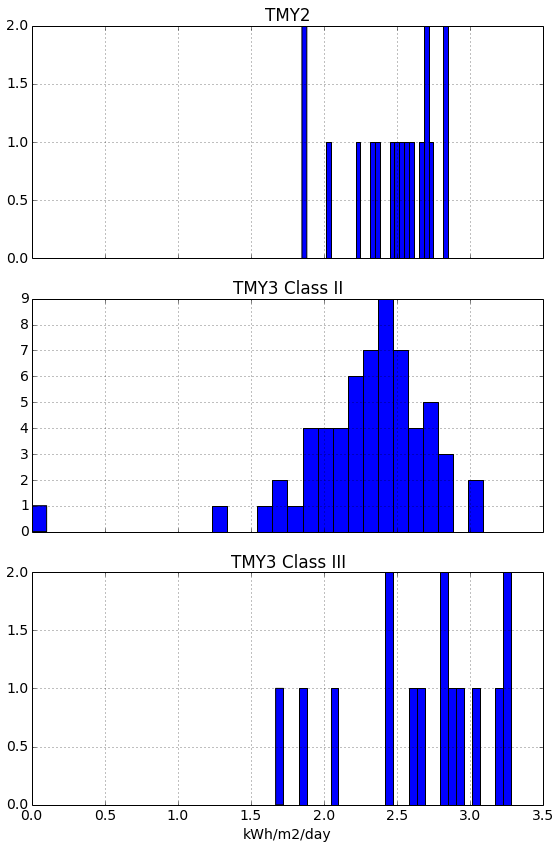

In [6]:
# Plot solar histograms of the various types of climate files

figure(figsize=(8,12))
subplots_adjust(hspace=0.001)

ax1 = subplot(311)
df.query('tmy_type == 2').south_vert_solar.hist(bins=30)
title('TMY2')
xlim(0, 3.5)

ax2 = subplot(312, sharex=ax1)
title('TMY3 Class II')
df.query('tmy_type == 3 and tmy_class=="II"').south_vert_solar.hist(bins=30)

ax3 = subplot(313, sharex=ax1)
title('TMY3 Class III')
df.query('tmy_type == 3 and tmy_class=="III"').south_vert_solar.hist(bins=30)
xlabel('kWh/m2/day')

xticklabels = ax1.get_xticklabels()+ax2.get_xticklabels()
setp(xticklabels, visible=False)

tight_layout()

In [7]:
# Find Low Solar sites.
df.query('south_vert_solar < 1.8')

,stn_id,stn_name,tmy_type,tmy_class,south_vert_solar,elevation,latitude,longitude
17,704540,Adak NAS,3,III,1.67,5,51.882999,-176.649994
32,702606,Chulitna,3,II,1.72,381,62.882999,-149.832993
33,703160,Cold Bay Arpt,3,II,1.74,29,55.200001,-162.716995
37,704890,Dutch Harbor,3,II,1.29,4,53.900002,-166.550003
77,704140,Shemya AFB,3,II,0.00,31,52.716999,174.117004
83,703080,St Paul Island Arpt,3,II,1.63,7,57.167000,-170.216995


In [8]:
# Find High Solar sites
df.query('south_vert_solar > 2.8')

,stn_id,stn_name,tmy_type,tmy_class,south_vert_solar,elevation,latitude,longitude
5,26415,Big Delta,2,NaN,2.85,388,64.000000,-145.733337
8,26425,Gulkana,2,NaN,2.85,481,62.150002,-145.449997
23,702320,Aniak Airport,3,III,3.02,26,61.583000,-159.533005
25,702075,Anvik,3,III,2.93,99,62.650002,-160.182999
31,702746,Birchwood,3,III,3.24,30,61.417000,-149.516998
41,701940,Fort Yukon,3,III,2.85,136,66.567001,-145.266998
44,703670,Gustavus,3,II,3.09,12,58.417000,-135.699997
60,702725,Lake Hood Seaplane,3,III,3.18,22,61.182999,-149.966995
64,702460,Minchumina,3,II,3.02,213,63.882999,-152.283005
65,702600,Nenana Municipal AP,3,II,2.85,109,64.550003,-149.100006


In [9]:
# Need to make this a valid path on your machine.
xlw = pd.ExcelWriter(r'C:\Users\Alan\Documents\GitHub\AkWarm\Analysis\Climate\solar_data.xlsx')
df.to_excel(xlw, index=False)
xlw.close()

IOError: [Errno 2] No such file or directory: 'C:\\Users\\Alan\\Documents\\GitHub\\AkWarm\\Analysis\\Climate\\solar_data.xlsx'

## Calculate Average Solar Uncertainty from TMY3 Sites

In [10]:
# Test reading a TMY3 file directly into Pandas DataFrame
tmy = pd.read_csv('http://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/data/tmy3/702725TYA.CSV', skiprows=1)
tmy.head()

,Date (MM/DD/YYYY),Time (HH:MM),ETR (W/m^2),ETRN (W/m^2),GHI (W/m^2),GHI source,GHI uncert (%),DNI (W/m^2),DNI source,DNI uncert (%),...,Alb (unitless),Alb source,Alb uncert (code),Lprecip depth (mm),Lprecip quantity (hr),Lprecip source,Lprecip uncert (code),PresWth (METAR code),PresWth source,PresWth uncert (code)
0,01/01/2002,01:00,0,0,0,1,0,0,1,0,...,0.55,F,8,0,1,D,9,0,C,8
1,01/01/2002,02:00,0,0,0,1,0,0,1,0,...,0.55,F,8,0,1,D,9,0,C,8
2,01/01/2002,03:00,0,0,0,1,0,0,1,0,...,0.55,F,8,0,1,D,9,0,C,8
3,01/01/2002,04:00,0,0,0,1,0,0,1,0,...,0.55,F,8,0,1,D,9,0,C,8
4,01/01/2002,05:00,0,0,0,1,0,0,1,0,...,0.55,F,8,0,1,D,9,0,C,8


In [11]:
# If the Pickle file exists, read the Uncertainty data from it, otherwise
# recreate the uncertainty data.
if os.path.exists('uncert.pkl'):
    print "Unpickling Uncertainty DataFrame"
    uncert = pd.read_pickle('uncert.pkl')
    
else:    
    results = []
    for id, site, tmy_class in tmy_ids.tmy3_ids:

        rec = {'stn_id': id, 'stn_name': site}

        # Read the TMY3 file into a Pandas DataFrame direct from the NREL site
        tmy = pd.read_csv('http://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/data/tmy3/%sTYA.CSV' % id, skiprows=1)

        # Calc GHI (Global Horizontal Insolation) weighted average uncertainty
        vals = tmy['GHI (W/m^2)'].values
        uncertainty = tmy['GHI uncert (%)'].values / 100.0
        avg_uncert = sum(vals * uncertainty) / sum(vals)
        rec['ghi_uncert'] = round(avg_uncert, 3)

        # Calc DNI (Direct Normal Insolation) weighted average uncertainty
        vals = tmy['DNI (W/m^2)'].values
        uncertainty = tmy['DNI uncert (%)'].values / 100.0
        avg_uncert = sum(vals * uncertainty) / sum(vals)
        rec['dni_uncert'] = round(avg_uncert, 3)

        results.append(rec)
        print site, rec['ghi_uncert'], rec['dni_uncert']

    # Make a DataFrame
    uncert = pd.DataFrame(results)

    # reorder columns
    uncert = uncert.reindex_axis(['stn_id', 'stn_name', 'ghi_uncert', 'dni_uncert'], axis=1)

    # Save it
    uncert.to_pickle('uncert.pkl')

uncert.head()    


Unpickling Uncertainty DataFrame


,stn_id,stn_name,ghi_uncert,dni_uncert
0,704540,Adak NAS,0.265,0.295
1,701718,Ambler,0.262,0.292
2,701625,Anaktuvuk Pass,0.264,0.294
3,702730,Anchorage Intl AP,0.110,0.138
4,702735,Anchorage Merrill Field,0.176,0.225


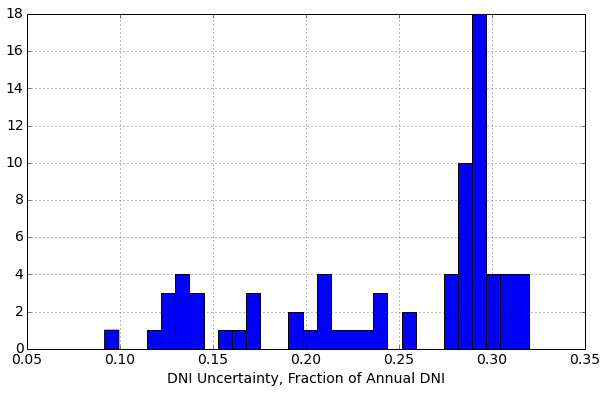

In [12]:
uncert.dni_uncert.hist(bins=30)
xlabel('DNI Uncertainty, Fraction of Annual DNI')

In [13]:
# Low Uncertainty Sites
df_low = uncert.query('dni_uncert < 0.22')
print len(df_low)
df_low

24


,stn_id,stn_name,ghi_uncert,dni_uncert
3,702730,Anchorage Intl AP,0.110,0.138
5,702720,Anchorage/Elmendorf,0.110,0.170
7,703980,Annette Island AP,0.108,0.124
9,700260,Barrow W Post-W Rogers Arpt [NSA - ARM],0.105,0.092
10,702190,Bethel Airport,0.113,0.130
11,701740,Bettles Field,0.113,0.137
12,702670,Big Delta Allen AAF,0.163,0.169
16,703160,Cold Bay Arpt,0.103,0.127
18,700637,Deadhorse,0.167,0.209
22,702610,Fairbanks Intl Arpt,0.112,0.116


In [14]:
# High Uncertainty Sites
uncert.query('dni_uncert > 0.27')

,stn_id,stn_name,ghi_uncert,dni_uncert
0,704540,Adak NAS,0.265,0.295
1,701718,Ambler,0.262,0.292
2,701625,Anaktuvuk Pass,0.264,0.294
6,702320,Aniak Airport,0.261,0.290
8,702075,Anvik,0.262,0.292
13,702986,Big River Lake,0.252,0.282
14,702746,Birchwood,0.265,0.294
15,702606,Chulitna,0.262,0.291
19,703210,Dillingham (AMOS),0.186,0.309
20,704890,Dutch Harbor,0.251,0.282


In [15]:
# Join the prior solar data with this data
df_all = pd.merge(uncert, df)

# make a label column with solar and uncertainty (rounded to two decimals) combined
df_all['label'] = df_all.south_vert_solar.map(str) + df_all.dni_uncert.map(lambda x: '-%.2f' % x)
df_all.head()

,stn_id,stn_name,ghi_uncert,dni_uncert,tmy_type,tmy_class,south_vert_solar,elevation,latitude,longitude,label
0,704540,Adak NAS,0.265,0.295,3,III,1.67,5,51.882999,-176.649994,1.67-0.29
1,701718,Ambler,0.262,0.292,3,II,2.49,88,67.099998,-157.850006,2.49-0.29
2,701625,Anaktuvuk Pass,0.264,0.294,3,III,2.45,657,68.133003,-151.733002,2.45-0.29
3,702730,Anchorage Intl AP,0.110,0.138,3,II,2.43,35,61.182999,-150.000000,2.43-0.14
4,702735,Anchorage Merrill Field,0.176,0.225,3,II,2.20,42,61.216999,-149.850006,2.2-0.23


In [ ]:
# Need to make this a valid path on your machine.
xlw = pd.ExcelWriter(r'C:\Users\Alan\Documents\GitHub\AkWarm\Analysis\Climate\solar_with_uncert.xlsx')
df_all.to_excel(xlw, index=False)
xlw.close()

In [16]:
%run solar_to_kml.py solar_with_uncert.xlsx

IOError: [Errno 2] No such file or directory: 'solar_with_uncert.xlsx'

In [ ]:
# Create a spreadsheet and map with just the Low Uncertainty sites
xlw = pd.ExcelWriter(r'C:\Users\Alan\Documents\GitHub\AkWarm\Analysis\Climate\solar_low_uncert.xlsx')
df_low = df_all.query('dni_uncert < 0.22')
df_low.to_excel(xlw, index=False)
xlw.close()

%run solar_to_kml.py solar_low_uncert.xlsx

## Final Solar Sites

In [17]:
# exclude the following sites:
#   Shemya, 704140 (PVWatts bug causes 0 solar)
#   Elmendorf, 702720 (have Anc Airport instead)
#   Deadhorse, 700637 (Barrow is lower uncertainty and Deadhorse/Barrow relationship is
#              not consistent with solar map)
#   Eielson,   702650 (use Fairbanks)
stns = set(df_low.stn_id.values)    # all of the low uncertainty stations
stns = stns - set([704140, 702720, 700637, 702650])     # remove the 4 stations above
mask = df_all.stn_id.isin(stns)
df_solar_final = df_all[mask]
df_solar_final

,stn_id,stn_name,ghi_uncert,dni_uncert,tmy_type,tmy_class,south_vert_solar,elevation,latitude,longitude,label
3,702730,Anchorage Intl AP,0.110,0.138,3,II,2.43,35,61.182999,-150.000000,2.43-0.14
7,703980,Annette Island AP,0.108,0.124,3,II,2.15,33,55.049999,-131.567001,2.15-0.12
9,700260,Barrow W Post-W Rogers Arpt [NSA - ARM],0.105,0.092,3,II,1.98,10,71.320000,-156.619995,1.98-0.09
10,702190,Bethel Airport,0.113,0.130,3,II,2.52,38,60.783001,-161.832993,2.52-0.13
11,701740,Bettles Field,0.113,0.137,3,II,2.73,196,66.917000,-151.516998,2.73-0.14
12,702670,Big Delta Allen AAF,0.163,0.169,3,II,2.73,386,64.000000,-145.716995,2.73-0.17
16,703160,Cold Bay Arpt,0.103,0.127,3,II,1.74,29,55.200001,-162.716995,1.74-0.13
22,702610,Fairbanks Intl Arpt,0.112,0.116,3,II,2.80,133,64.817001,-147.850006,2.8-0.12
26,702710,Gulkana Intermediate Field,0.114,0.143,3,II,2.64,478,62.150002,-145.449997,2.64-0.14
30,703410,Homer Arpt,0.112,0.209,3,II,2.44,27,59.650002,-151.483002,2.44-0.21


In [18]:
df_solar_final.to_csv("final_solar_sites.csv")

In [47]:
# Create a spreadsheet and map with just the final sites
xlw = pd.ExcelWriter(r'C:\Users\Alan\Documents\GitHub\AkWarm\Analysis\Climate\solar_final_sites.xlsx')
df_solar_final.to_excel(xlw, index=False)
xlw.close()

%run solar_to_kml.py solar_final_sites.xlsx